<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# IMAGE SEGMENTATION
Image segmentation. It is the process of partition a digital image into different regions called segments based on the characteristics of pixels. Segments of connected pixels are created by	analyzing some	similarity	criteria such intensity, texture, color, features,	histogram etc. When a label is assign to a pixel, pixels with the same label are “homogeneous”, that is, the “same” in some sense.

Image segmentation methods can be classified into three categories groups namely,

$\bf{ Instance \ segmentation:}$ the goal is to detect and localize an object in an image. It detects each distinct object of interest in the image.  Instance segmentation treats multiple objects of the same class as distinct individual instances.

$\bf{Semantic \ segmentation}$  goal is to identify , for every pixel, a belonging class of the object. For example, when all people are segmented as one object and background as one object. It treats multiple objects of the same class as a single entity.

$\bf{ panoptic \ segmentation:}$ combines the concepts of both semantic and instance segmentation. 

# SEMANTIC SEGMENTION

Semantic segmentation partition an image into regions belonging to different semantic classes and has been used in applications including  autonomous driving, medical imaging, and satellite image analysis.


In [1]:
import os,math, random
from skimage import io,color
from skimage.transform import resize as sc_resize
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline
plt.rcParams['image.cmap']='gray'
tf.random.set_seed(1000)
np.random.seed(1000)
plt.ion()

!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
#!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
#!tar -xf images.tar.gz
#!tar -xf annotations.tar.gz

In [2]:
input_dir = "../data/images/"
target_dir = "../data/annotations/trimaps/"

In [3]:
input_img_paths=sorted(
                    [ os.path.join(input_dir,img_name)for img_name in os.listdir(input_dir) if img_name.endswith('.jpg') ]
                    )

target_img_paths=sorted(
                   [ os.path.join(target_dir,tar_img_name) for tar_img_name in os.listdir(target_dir)
                    if tar_img_name.endswith('.png') and not tar_img_name.startswith('.')
                   ])

In [4]:
print('number of smaples images', len(input_img_paths))


number of smaples images 7390


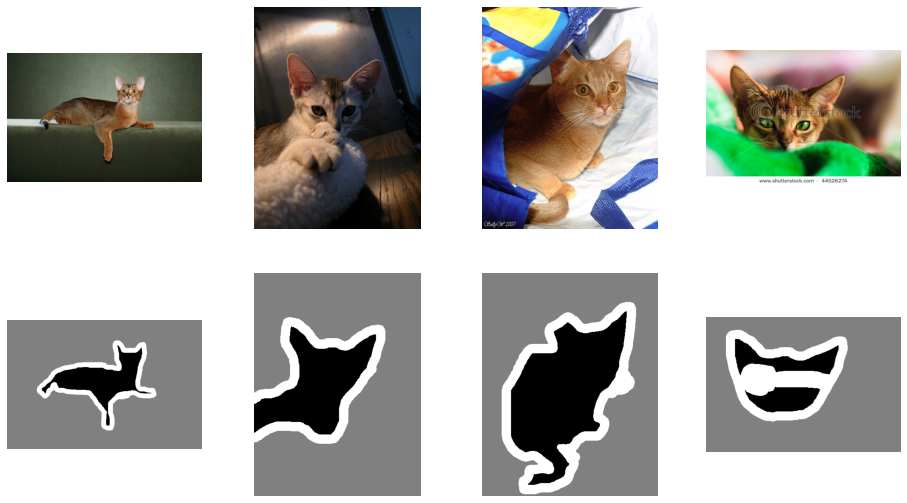

In [5]:
imgs=input_img_paths[:4]+target_img_paths[:4]
plt.figure(figsize=(16,9))
for i,c in enumerate(imgs):
    plt.subplot(2,4,i+1)
    plt.imshow(io.imread(c))
    plt.axis('off')

In [6]:
keras.backend.clear_session()
img_size = (224,224)
num_classes = 3
batch_size = 50

class OxfordPetsDateset(keras.utils.Sequence):
    def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.input_img_paths=input_img_paths
        self.target_img_paths=target_img_paths
        
        
    def __len__(self):
        return len(self.target_img_paths)//self.batch_size
    
    def __getitem__(self,idx):
        batch_input_img_paths=self.input_img_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_paths=self.target_img_paths[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x=np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        batch_y=np.zeros((self.batch_size,)+self.img_size+(1,),dtype='uint8')
        
        for i,img in enumerate(batch_input_img_paths):
            img=load_img(img, target_size=self.img_size)
            img/=np.max(img)
            batch_x[i]=img
            
        for i,img in enumerate(batch_target_img_paths):
            #img=load_img(img, target_size=self.img_size, color_mode="grayscale")
            img=cv2.imread(img,0)
            img=cv2.resize(img,self.img_size)
            batch_y[i]=tf.expand_dims(img,axis=2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            batch_y[i]-=1
        return batch_x,batch_y

In [7]:

# Split our img paths into a training and a validation set
val_samples = 1000
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
# Instantiate data Sequences for each split
train_gen = OxfordPetsDateset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPetsDateset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# Full Convolutional Networks



An FCN naturally operates on an input of any size, and produces an output of corresponding (possibly resampled) spatial dimensions . ([Fully Convolutional Networks for Semantic Segmentation,2015](https://arxiv.org/pdf/1411.4038.pdf))

It transforms the height and width of intermediate feature maps back to those of the input image through the use of a transposed convolutional layer and the channel dimension at any output pixel holds the classification results for the input pixel at the same spatial position

While a general deep net computes a general nonlinear function, a net with only layers of this form computes a nonlinear filter, which we call a deep filter or fully convolutional network ([Fully Convolutional Networks for Semantic Segmentation,2015](https://arxiv.org/pdf/1411.4038.pdf))


FCN uses a CNN to extract image features, then append a 1 × 1 convolution to transforms the number of channels into the number of classes. it then transforms the height and width of the feature maps to those of the input image via the transposed convolution. As a result, the model output has the same height and width as the input image, where the output channel contains the predicted classes for the input pixel at the same spatial position
([13.11.1. The Model ](https://d2l.ai/chapter_computer-vision/fcn.html)  )

In [8]:
keras.backend.clear_session()

In [9]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1),np.arange(kernel_size).reshape(1, -1))
    filt = (1 - np.abs(og[0] - center) / factor) * (1 - np.abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight)
K=tf.keras.initializers.Constant(bilinear_kernel(3,3,16))

In [10]:
pretrained=keras.applications.VGG16(include_top=False,input_shape=(224,224,3))  

In [11]:
#pretrained.summary()

In [12]:
inputs=pretrained.layers[0].input
x=pretrained.layers[-2].output
x=keras.layers.Conv2D(num_classes,kernel_size=1)(x)
x=keras.layers.Activation('relu')(x)
output=keras.layers.Conv2DTranspose(num_classes,kernel_size=16,strides=16,kernel_initializer=K)(x)
output=keras.layers.Activation('softmax')(output)
model=keras.Model(inputs,output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [81]:
#model.summary()

In [82]:
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

# References

[A guide to convolution arithmetic for deep learning,2018](https://arxiv.org/abs/1603.07285)

[Is the deconvolution layer the same as a convolutional layer?,2016](https://arxiv.org/ftp/arxiv/papers/1609/1609.07009.pdf)


[Fully Convolutional Networks for Semantic Segmentation,2015](https://arxiv.org/pdf/1411.4038.pdf)

[13.11. Fully Convolutional Networks](https://d2l.ai/chapter_computer-vision/fcn.html)


[Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)